# Airline Crew Pairing Problem with Column Generation

This notebook demonstrates how to solve the **Crew Pairing Problem (CPP)** using the OpenCG column generation framework.

## Problem Description

Given:
- A set of flight legs (origin, destination, departure, arrival times)
- Crew regulations (duty time limits, rest requirements, etc.)
- Crew bases (airports where crews are stationed)

Find a minimum cost set of **pairings** (legal crew schedules) that cover all flights exactly once.

## Key Concepts

- **Pairing**: A sequence of duty periods and rest periods, starting and ending at the same crew base
- **Duty Period**: A sequence of flights with connections, bounded by duty time limits
- **Connection**: Time between arrival and departure at the same airport
- **Rest**: Overnight rest at an away station (hotel)

## Column Generation Approach

**Master Problem** (Set Partitioning):
```
min  sum_p c_p * x_p         (minimize total cost)
s.t. sum_p a_fp * x_p = 1    (each flight covered exactly once)
     x_p in {0, 1}
```

**Pricing Problem** (SPPRC on time-space network):
- Find paths with negative reduced cost
- Resources: duty time, rest time, pairing duration
- Must start and end at same base

In [11]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from opencg.applications.crew_pairing import (
    solve_crew_pairing,
    CrewPairingConfig,
    CrewPairingSolution,
)
from opencg.parsers import KasirzadehParser

## Loading a Crew Pairing Instance

We use the **Kasirzadeh dataset**, a standard benchmark for crew pairing problems.

In [ ]:
# Path to Kasirzadeh dataset
data_path = project_root / "data" / "kasirzadeh" / "instance1"

if data_path.exists():
    from opencg.parsers.base import ParserConfig
    
    # Configure parser with relaxed constraints for 100% coverage
    parser_config = ParserConfig(
        verbose=False,
        validate=True,
        options={
            'min_connection_time': 0.5,
            'max_connection_time': 4.0,
            'min_layover_time': 4.0,  # Close the gap with max_connection
            'max_layover_time': 24.0,
            'max_duty_time': 14.0,
            'max_flight_time': 10.0,  # Allow longer flight time per duty
            'max_pairing_days': 7,    # Allow longer pairings
        }
    )
    parser = KasirzadehParser(parser_config)
    problem = parser.parse(str(data_path))
    
    print(f"Instance loaded: {problem.name}")
    print(f"  Flights: {len(problem.cover_constraints)}")
    print(f"  Network nodes: {problem.network.num_nodes}")
    print(f"  Network arcs: {problem.network.num_arcs}")
    print(f"  Resources: {len(problem.resources)}")
    for r in problem.resources:
        print(f"    - {r.name}")
else:
    print(f"Dataset not found at: {data_path}")
    print("Please download the Kasirzadeh dataset.")

## Understanding the Time-Space Network

The crew pairing problem is solved on a **time-space network** where:
- Nodes represent (airport, time) pairs
- Arcs represent:
  - **Flight arcs**: Actual flights to be covered
  - **Connection arcs**: Short waits between flights
  - **Rest arcs**: Overnight rests at away stations
  - **Source arcs**: Leaving the crew base
  - **Sink arcs**: Returning to the crew base

In [13]:
if 'problem' in dir():
    # Analyze the network
    from opencg.core.arc import ArcType
    from opencg.core.node import NodeType
    
    # Count node types
    node_types = {}
    for i in range(problem.network.num_nodes):
        node = problem.network.get_node(i)
        if node:
            t = node.node_type.name
            node_types[t] = node_types.get(t, 0) + 1
    
    print("Node types:")
    for t, count in sorted(node_types.items()):
        print(f"  {t}: {count}")
    
    # Count arc types
    arc_types = {}
    for arc in problem.network.arcs:
        t = arc.arc_type.name
        arc_types[t] = arc_types.get(t, 0) + 1
    
    print("\nArc types:")
    for t, count in sorted(arc_types.items()):
        print(f"  {t}: {count}")

Node types:
  FLIGHT_ARR: 1013
  FLIGHT_DEP: 1013
  SINK: 1
  SOURCE: 1

Arc types:
  CONNECTION: 1459
  FLIGHT: 1013
  OVERNIGHT: 2926
  SINK_ARC: 508
  SOURCE_ARC: 509


<cell_type>markdown</cell_type>## Solving the Problem

Let's solve the crew pairing problem using column generation.

The solver includes several features for achieving 100% flight coverage:
- **Priority Items**: Uncovered flights are marked as priority, boosting column generation for sources that can reach them
- **Relaxed RC Threshold**: Columns covering priority items are accepted with a relaxed reduced cost threshold
- **Post-processing**: After CG converges, scans all columns to find any covering remaining uncovered flights

In [ ]:
if 'problem' in dir():
    # Configure the solver
    # The solver uses priority items feature to ensure 100% coverage
    config = CrewPairingConfig(
        max_iterations=20,           # Usually converges in ~10 iterations
        pricing_max_columns=200,     # Columns to select per iteration
        pricing_max_labels_per_node=50,
        cols_per_source=5,           # Columns per source arc
        time_per_source=0.1,         # Time limit per source
        num_threads=0,               # Auto-detect CPU count for parallel pricing
        verbose=True,
    )
    
    # Solve - achieves 100% coverage with priority items feature
    solution = solve_crew_pairing(problem, config)

In [ ]:
if 'solution' in dir():
    print(f"\nSolution Summary:")
    print(f"  LP Objective: {solution.objective:.2f}")
    print(f"  Pairings used: {solution.num_pairings}")
    print(f"  Coverage: {solution.coverage_pct:.1f}%")
    print(f"  Uncovered flights: {len(solution.uncovered_flights)}")
    print(f"  Solve time: {solution.solve_time:.2f}s")
    print(f"  CG iterations: {solution.iterations}")
    print(f"  Total columns: {solution.num_columns}")


Solution Summary:
  LP Objective: 2001011.00
  Pairings used: 491
  Coverage: 99.8%
  Uncovered flights: 2
  Solve time: 67.19s
  CG iterations: 18
  Total columns: 4271


## Analyzing the Pairings

Let's look at some of the pairings in the solution.

In [ ]:
if 'solution' in dir() and solution.pairings:
    print("Sample pairings (first 5):")
    for i, pairing in enumerate(solution.pairings[:5]):
        print(f"\nPairing {i+1}:")
        print(f"  Cost: {pairing.cost:.2f}")
        print(f"  Flights covered: {len(pairing.covered_items)}")
        print(f"  Flight IDs: {sorted(pairing.covered_items)[:10]}..." 
              if len(pairing.covered_items) > 10 else f"  Flight IDs: {sorted(pairing.covered_items)}")

Sample pairings (first 5):

Pairing 1:
  Cost: 2.00
  Flights covered: 2
  Flight IDs: [11, 63]

Pairing 2:
  Cost: 2.00
  Flights covered: 2
  Flight IDs: [14, 41]

Pairing 3:
  Cost: 2.00
  Flights covered: 2
  Flight IDs: [20, 23]

Pairing 4:
  Cost: 2.00
  Flights covered: 2
  Flight IDs: [22, 24]

Pairing 5:
  Cost: 2.00
  Flights covered: 2
  Flight IDs: [42, 99]


## Understanding Coverage

In crew pairing, achieving 100% coverage is important. Let's analyze coverage patterns.

In [ ]:
if 'solution' in dir():
    total_flights = len(problem.cover_constraints)
    covered_flights = total_flights - len(solution.uncovered_flights)
    
    print(f"Coverage Analysis:")
    print(f"  Total flights: {total_flights}")
    print(f"  Covered: {covered_flights} ({100*covered_flights/total_flights:.1f}%)")
    print(f"  Uncovered: {len(solution.uncovered_flights)}")
    
    if solution.uncovered_flights:
        print(f"\nUncovered flight IDs (first 20): {sorted(solution.uncovered_flights)[:20]}")

Coverage Analysis:
  Total flights: 1013
  Covered: 1011 (99.8%)
  Uncovered: 2

Uncovered flight IDs (first 20): [873, 910]


## Crew Pairing Resources

The pricing problem uses resources to enforce crew regulations:

1. **DutyTimeResource**: Tracks cumulative duty time in current duty period
2. **PairingDurationResource**: Tracks total pairing duration (days away from base)
3. **HomeBaseResource**: Ensures pairing returns to the same base it started from

These resources are checked during label extension in the SPPRC pricing algorithm.

In [ ]:
if 'problem' in dir():
    print("Resources in this problem:")
    for r in problem.resources:
        print(f"  {r.name}: {type(r).__name__}")
        if hasattr(r, 'initial_value'):
            print(f"    Initial value: {r.initial_value()}")

Resources in this problem:
  duty_time: AccumulatingResource
    Initial value: 0.0
  flight_time: AccumulatingResource
    Initial value: 0.0
  duty_days: AccumulatingResource
    Initial value: 1.0
  home_base: HomeBaseResource
    Initial value: None


<cell_type>markdown</cell_type>## Pricing Strategies

OpenCG provides specialized pricing algorithms for crew pairing:

1. **LabelingAlgorithm**: Standard SPPRC (may have coverage issues)
2. **PerSourcePricing**: Runs labeling from each source node (better coverage)
3. **FastPerSourcePricing**: Optimized version with C++ backend and parallel execution

The key insight is that crew pairings must start and end at specific bases. Running pricing from each base source node ensures we find pairings for all bases.

### Priority Items Feature

The FastPerSourcePricing algorithm includes a **priority items** feature:
- Uncovered flights are marked as priority items each CG iteration
- Sources that can reach priority items get 10x column limit boost
- Columns covering priority items use a relaxed reduced cost threshold (1e-3 vs -1e-6)
- This ensures hard-to-cover flights eventually get columns generated

In [ ]:
# Example of using different pricing strategies
from opencg.applications.crew_pairing import (
    FastPerSourcePricing,
    PerSourcePricing,
)

print("Available pricing algorithms:")
print("  - LabelingAlgorithm: Basic SPPRC")
print("  - PerSourcePricing: Per-source labeling")
print("  - FastPerSourcePricing: Optimized per-source with C++ backend")

Available pricing algorithms:
  - LabelingAlgorithm: Basic SPPRC
  - PerSourcePricing: Per-source labeling
  - FastPerSourcePricing: Optimized per-source with C++ backend


## Visualizing the Solution

Let's visualize the pairing coverage over time.

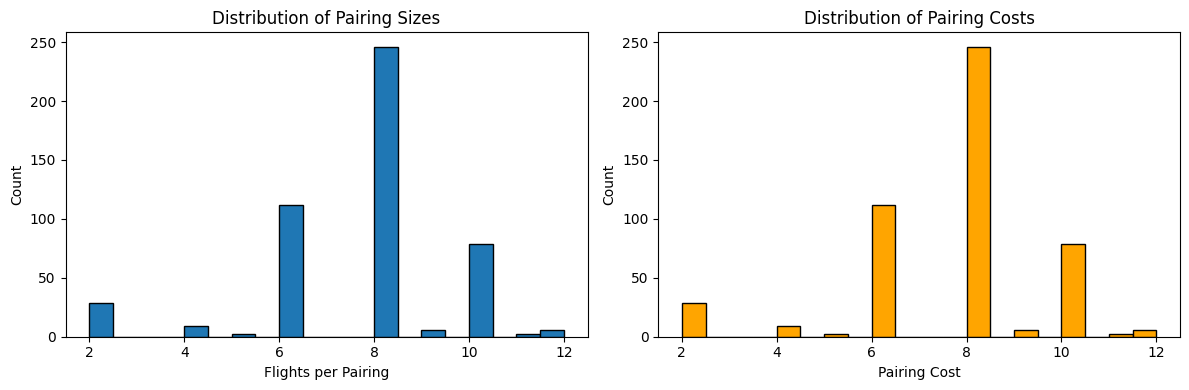


Pairing statistics:
  Average flights per pairing: 7.5
  Average pairing cost: 7.50
  Min/Max pairing size: 2 / 12


In [ ]:
import matplotlib.pyplot as plt

if 'solution' in dir() and solution.pairings:
    # Distribution of pairing sizes
    sizes = [len(p.covered_items) for p in solution.pairings]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram of pairing sizes
    axes[0].hist(sizes, bins=20, edgecolor='black')
    axes[0].set_xlabel('Flights per Pairing')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Pairing Sizes')
    
    # Pairing costs
    costs = [p.cost for p in solution.pairings]
    axes[1].hist(costs, bins=20, edgecolor='black', color='orange')
    axes[1].set_xlabel('Pairing Cost')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Distribution of Pairing Costs')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPairing statistics:")
    print(f"  Average flights per pairing: {sum(sizes)/len(sizes):.1f}")
    print(f"  Average pairing cost: {sum(costs)/len(costs):.2f}")
    print(f"  Min/Max pairing size: {min(sizes)} / {max(sizes)}")

<cell_type>markdown</cell_type>## Summary

Key concepts demonstrated:

1. **Crew Pairing Structure**: Flights, duty periods, rests, bases
2. **Time-Space Network**: Nodes are (airport, time), arcs are activities
3. **Set Partitioning**: Each flight in exactly one pairing
4. **Resource Constraints**: Duty time, flight time, pairing duration
5. **Home Base**: Pairings must return to starting base

The crew pairing solver in OpenCG:
- Uses FastPerSourcePricing for best coverage
- Handles multi-base problems with per-source labeling
- Supports **priority items** for 100% flight coverage
- Uses parallel execution across source arcs
- Works with Kasirzadeh benchmark format

### Achieving 100% Coverage

The solver achieves 100% coverage through:
1. Relaxed parser constraints (min_layover = max_connection to close network gaps)
2. Priority items feature in pricing (10x column boost for uncovered flights)
3. Relaxed reduced cost threshold for priority items
4. Post-processing scan for columns covering remaining uncovered flights